In [312]:
# Data Procesing
import pandas as pd 
import numpy as np
import re

# Data Cleansing
import spacy # Note-1
import nltk
from nltk.corpus import stopwords
from guess_language import guessLanguage # Note-3
from autocorrect import Speller # Note-4

# Modeling
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# Visualization
from pprint import pprint
from tqdm import tqdm
import pyLDAvis   # Note-2    
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px
from bokeh.plotting import figure, output_file, show
from bokeh.palettes import Spectral6

from IPython.display import display, Markdown

# Notes:

# Note-1
# https://stackoverflow.com/questions/54334304/spacy-cant-find-model-en-core-web-sm-on-windows-10-and-python-3-5-3-anacon
# python -m spacy download en_core_web_lg [To be executed in Anaconda Terminal]
# python -m spacy download en_core_web_sm [To be executed in Anaconda Terminal]
# python -m spacy download en             [To be executed in Anaconda Terminal]

# Note-2 
# https://stackoverflow.com/questions/66759852/no-module-named-pyldavis
# pip install pyLDAvis [To be executed in Anaconda Terminal]

# Note-3
# https://stackoverflow.com/questions/13551969/how-to-install-the-guess-language-package-in-python
# pip install guess_language

# Note-4
# pip install autocorrect

# To ignore warnings
import warnings
#from pandas.core.common import SettingWithCopyWarning
warnings.filterwarnings("ignore", category= DeprecationWarning) 

In [255]:
original_df = pd.read_csv('NLP_DatasetFinal.csv', engine='python')
original_df.columns = ["month","full_date","location","channel","first_tag","sentiment","comments"]
#print(original_df.shape)
#original_df.head()

In [ ]:
count_first_tag = original_df.groupby('first_tag', dropna=False)["month"].count().reset_index(name='counts')
pd.set_option('display.max_rows', 12)
pd.set_option("display.max_colwidth", 100)
pd.DataFrame(count_first_tag).sort_values('counts', ascending=False)

In [272]:
# 2- Data Cleansing Code
def removing_empty_comments(input_df):
    return input_df[input_df["comments"].notnull()]

def removing_non_alpahumerics(input_df):
    input_df["comments"] = input_df["comments"].astype(str).apply(lambda x: re.sub(r'[^A-Za-z0-9 ]+', '', x))
    return input_df

# Applying Guess Language
def removing_empty_comments(input_df):
    return input_df[input_df["comments"].notnull()]

def guessing_language(input_df):
    input_df['main_language'] = input_df['comments'].apply(lambda x: guessLanguage(x))
    return input_df

def removing_short_comments(input_df, min_length = 20):
    return input_df[input_df["comments"].str.len() >= min_length]

def guessing_language(input_df):
    input_df['main_language'] = input_df['comments'].apply(lambda x: guessLanguage(x))
    return input_df

def removing_foreign_comments(input_df): 
    input_df = guessing_language(input_df)
    return input_df[input_df["main_language"] == "en"]

def transforming_digits(input_df):
    # Convertinz 0 => zero, 1 => one, 2 => pair. Then convert the rest of the digits into word "digit"
    input_df["comments"] = input_df["comments"].astype(str).apply(lambda x: re.sub(r'\d{2,}', 'digit', x))
    input_df["comments"] = input_df["comments"].astype(str).apply(lambda x: re.sub(r'0', 'zero', x))
    input_df["comments"] = input_df["comments"].astype(str).apply(lambda x: re.sub(r'1', 'one', x))
    input_df["comments"] = input_df["comments"].astype(str).apply(lambda x: re.sub(r'2', 'pair', x))
    input_df["comments"] = input_df["comments"].astype(str).apply(lambda x: re.sub(r'\d', 'digit', x)) 
    return input_df

def transforming_double_ws(input_df):
    input_df["comments"] = input_df["comments"].astype(str).apply(lambda x: re.sub(r"[\s]+", ' ', x))
    return input_df

def transforming_uppercase(input_df):
    input_df["comments"] = input_df["comments"].map(lambda x: x.lower())
    return input_df

def ploting_term_distribution(term_freq_distr):
    term_freq_df = pd.DataFrame(term_freq_distr.items(), columns=['term', 'frequency'])
    term_freq_df_top20 = term_freq_df.sort_values("frequency", ascending = False).iloc[:10]
    plt.bar(term_freq_df_top20['term'], term_freq_df_top20['frequency'])
    plt.rcParams["figure.figsize"] = (20, 5)
    plt.rcParams['xtick.labelsize'] =15
    plt.xlabel('Term', fontsize=17)
    plt.ylabel('Frequency', fontsize=15)

def cleansing_dataset(input_df):
    no_nan_df = removing_empty_comments(input_df)
    non_alphanum = removing_non_alpahumerics(no_nan_df)
    no_short_comments = removing_short_comments(non_alphanum)
    no_foreign_comments = removing_foreign_comments(no_short_comments)
    no_digits = transforming_digits(no_foreign_comments)
    no_double_ws = transforming_double_ws(no_digits)
    lower_case = transforming_uppercase(no_double_ws)
    return lower_case

def invalid_records(original_df):
    original_length = len(original_df)

    no_nan_comments = removing_empty_comments(original_df)
    no_nan_comments_length = len(no_nan_comments)

    no_short_comments = removing_short_comments(no_nan_comments)
    no_short_comments_length = len(no_short_comments)

    no_foreign_comments = removing_foreign_comments(no_short_comments)
    no_foreign_comments_length = len(no_foreign_comments)


    filtering_progress = {
        "step": ["original", "no_nan", "no_short", "no_foreign"],
        "count": [original_length, no_nan_comments_length, no_short_comments_length, no_foreign_comments_length]
    }

    filtering_progress_df = pd.DataFrame(filtering_progress)

    return filtering_progress_df

In [273]:
# 3- NLP Processing
def sentence_to_tokens(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
def lemmatization(sentences, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

    output = []
    for sentence in sentences:
        doc = nlp(" ".join(sentence)) 
        output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return output

# Build the bigram and trigram models
def phrare_modeling_bigrams(sentences):
    bigram = gensim.models.Phrases(sentences, min_count=5, threshold=100) # higher threshold fewer phrases.

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)

    return [bigram_mod[doc] for doc in sentences]
   
def phrare_modeling_trigrams(sentences):
    bigram = gensim.models.Phrases(sentences, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[sentences], threshold=100)

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    return [trigram_mod[bigram_mod[doc]] for doc in sentences]

# List of stop words provided by nltk.corpus.stopwords
def remove_stopwords(sentences, custom_stop_words = []):
    stop_words = stopwords.words("english") #179 
    stop_words = [word.replace("\'", "") for word in stop_words]
    stop_words.extend(custom_stop_words)
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in sentences]

def token_lemma_phrasemodeling(lines, lemma_tags = ['NOUN', 'ADJ', 'VERB', 'ADV']):
    '''
        Applying nlp to a single text - Used during validation
    '''
    tokenized = list(sentence_to_tokens(lines))
    lemmanized = lemmatization(tokenized, allowed_postags = lemma_tags)
    data_words_bigrams = phrare_modeling_bigrams(lemmanized)
    
    return data_words_bigrams

def token_lemma_phrasemodeling_stopwords_multiline(lines, custom_stop_words = [], lemma_tags = ['NOUN', 'ADJ', 'VERB', 'ADV']):
    '''
        Applying nlp to a single text - Used during validation
    '''
    tokenized = list(sentence_to_tokens(lines))
    lemmanized = lemmatization(tokenized, allowed_postags = lemma_tags)
    data_words_bigrams = phrare_modeling_bigrams(lemmanized)
    no_stop_words = remove_stopwords(data_words_bigrams, custom_stop_words)
      
    return no_stop_words


def term_freq_distribution(words_list):
    words_ns = []
    for sentence in words_list:
        words_ns += sentence
    term_freq = nltk.FreqDist(words_ns)    
    return term_freq

def graph_n_most_freq_words(term_freq_distr, topn):
    
    plt.rcParams["figure.figsize"] = (20,5)
    plt.rcParams['xtick.labelsize'] =15
    plt.xlabel('xlabel', fontsize=17)
    plt.ylabel('ylabel', fontsize=15)
    term_freq_distr.plot(topn)

def inspecting_n_most_freq_words(comment_list, ntop = 30):
    # Calculating Term Frequency for the provided list of comments
    term_freq = term_freq_distribution(comment_list)
    
    # Converting the term_freq into df
    term_freq_df = pd.DataFrame(term_freq.items(), columns=['term', 'frequency'])
    
    pd.set_option('display.max_rows', ntop)
    display(term_freq_df.sort_values('frequency', ascending = False).iloc[:ntop])
    return term_freq_df

def generating_custom_stop_words(term_freq_df, freq_words_to_keep):
    # Determining the upper and lower threshold for extreme words
    freq_20th_top = term_freq_df.sort_values('frequency', ascending = False).iloc[20]['frequency']
    freq_85_quant = term_freq_df.frequency.quantile(0.85)
    
    # Selecting Extreme words
    most_frequent_terms = term_freq_df[term_freq_df['frequency'] > freq_20th_top]["term"].tolist()
    least_frequent_terms = term_freq_df[term_freq_df['frequency'] < freq_85_quant]["term"].tolist()
    
    # Combining upper and lower extreme words BUT freq_words_to_keep
    custom_stop_words = least_frequent_terms + [term for term in most_frequent_terms if term not in freq_words_to_keep]
    
    return custom_stop_words

def show_quantiles(term_freq_df):
    q50 = term_freq_df.frequency.quantile(.5)
    q75 = term_freq_df.frequency.quantile(.75)
    q90 = term_freq_df.frequency.quantile(.85)
    q99 = term_freq_df.frequency.quantile(.99)

    term_distribution = {
        "Quantile": ["Q50", "Q75", "Q85", "Q99"],
        "Count": [q50, q75, q90, q99]
    }

    term_distribution_df = pd.DataFrame(term_distribution).sort_values("Count", ascending = False)
    display(term_distribution_df)

In [126]:
# 4 Data Transformation
def generating_id2word(text_list_cleansed):
    return corpora.Dictionary(text_list_cleansed)

def generating_corpus_for_text(index2word, text):
    return index2word.doc2bow(text)

def generating_corpus_for_texts(index2word, texts):
    return [index2word.doc2bow(text) for text in texts]

def generating_id2word_and_corpus(data_processed):
    # Create Dictionary
    id2word = generating_id2word(data_processed)

    # Create Corpus
    corpus = generating_corpus_for_texts(id2word, data_processed)
    
    return id2word, corpus

In [ ]:
custom_stopwords_file = open('stop_words_custom.txt', 'r')
custom_stopwords_list = [line.rstrip('\n') for line in custom_stopwords_file.readlines()]
print(len(custom_stopwords_list))

In [350]:
# Topic Modeling with LDA

def compute_lda_model(corpus, dictionary, k, a, e):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=e)
    return lda_model

# Let's calculate the baseline coherence score 
def compute_coherence_values(model, data_lemmatized, id2word, coherence_method = 'c_v'):
    
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=model, 
                                         texts=data_lemmatized, 
                                         dictionary=id2word, 
                                         coherence=coherence_method)

    return coherence_model_lda.get_coherence()

def number_topics_range(corpus, id2word, processed_data, min_topics = 2, max_topics = 15):    
    model_results = {'Topics': [],
                     'Alpha': [],
                     'Beta': [],
                     'Coherence': []
                    }

    # Defining range of the topics
    step_size = 1
    topics_range = range(min_topics, max_topics, step_size)

    # Coputing Coherence Score for each number of topcis
    for num_t in tqdm(topics_range):
        alpha = num_t/10
        beta = num_t/10
        lda_model = compute_lda_model(corpus, id2word, num_t, alpha, beta)
        coherence_lda = compute_coherence_values(lda_model, processed_data, id2word)

        model_results['Topics'].append(num_t)
        model_results['Alpha'].append(alpha)
        model_results['Beta'].append(beta)
        model_results['Coherence'].append(coherence_lda)


    results_df = pd.DataFrame(model_results)
    
    # Show graph
    plt.plot(topics_range, results_df['Coherence'])
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.title("Coherence based on Num of Topics")
    plt.show()
    
# Wrapping the Hyperparameter tunning into a function
def hyperparameter_tunning(min_topics, max_topics, _corpus, _id2word, _texts):

    # Topics range
    topics_range = range(min_topics, max_topics, 1)

    # Alpha parameter
    alpha = list(np.arange(0.1, 1, 0.3))
    alpha.append('symmetric')
    alpha.append('asymmetric')

    # Eta parameter
    eta = list(np.arange(0.1, 1, 0.3))
    eta.append('symmetric')

    model_results = {'Topics': [],
                     'Alpha': [],
                     'Eta': [],
                     'Coherence': []
                    }

    # Can take a long time to run

    pbar = tqdm(total=80) # 2*(max_topics-min_topics+1)*len(alpha)*len(eta)

    # iterate through number of topics
    for k in topics_range:

        # iterate through alpha values
        for a in alpha:

            # iterare through beta values
            for e in eta:

                # Calculating the LDA model
                lda_model = compute_lda_model(_corpus, _id2word, k, a, e)
                pbar.update(1)

                # Calculating the Coherence Score 
                coherence_lda = compute_coherence_values(lda_model, _texts, _id2word)

                pbar.update(1)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Eta'].append(e)
                model_results['Coherence'].append(coherence_lda)

    pbar.close()

    results = pd.DataFrame(model_results)
    
    pd.set_option('display.max_rows', 10)
    results_sorted = results.sort_values('Coherence', ascending=False)
    display(results_sorted.head(10))
    
    return results_sorted.iloc[0]['Topics'], results_sorted.iloc[0]['Alpha'], results_sorted.iloc[0]['Eta']

def visualize_keywords_per_topic(model):
    pprint(model.print_topics())
    
# Assigning the Dominant Topic to the entire dataset
def assign_dominant_topic(model, id2word, dataset, topics_mapping):
    # Processing each comment to assing a corpus column
    dataset['corpus_comment'] = dataset.comments_processed.apply(lambda x: generating_corpus_for_text(id2word, x))
    
    dataset = dataset.apply(lambda row: get_dominant_topic_sentence(model, row, topics_mapping), axis=1)
    return dataset


# Capturing any Topic which has many keywords in common with a given sentence
def get_dominant_topic_sentence(lda_model, row, topics_mapping):
    
    # Getting topic score per sentence, sorthing that value
    topic_score = lda_model[row['corpus_comment']]
    topic_score_sorted = sorted(topic_score, key=lambda x: (x[1]), reverse=True)
   
    # If we have 3 topics, any topic with a relevance over 40% will be taken into account
    number_of_topics = len(topics_mapping)
    topic_relevance_threshold = 1.2/number_of_topics 
    main_topic = []
    main_keywords = []

    
    # We will consider any topic which relevance goes beyond that threshold
    for t in topic_score_sorted:
        if t[1] > topic_relevance_threshold:
            main_topic.append(topics_mapping[t[0]])
            kw = lda_model.show_topic(t[0])
            main_keywords.append([", ".join([word for word, prop in kw])])
            
    row['dominant_topic'] = main_topic
    row['key_words'] = main_keywords
    row['topic_score'] = topic_score_sorted
    
    return row

def generate_word_cloud(model, topic, topn = 30):
    # Get topics and frequencies and store in a dictionary structure
    topic_words_freq_wc = dict(model.show_topic(topic, topn=topn)) # NB. the 'dict()' constructor builds dictionaries from sequences (lists) of key-value pairs - this is needed as input for the 'generate_from_frequencies' word cloud function

    Markdown('## <strong>{}</strong><br/>'.format(topics_mapping[topic]))

    # Generate Word Cloud for topic using frequencies
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(topic_words_freq_wc) 
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
    
def plot_weekly_ts(df_grouped):
    p = figure(width=1200, height=500, x_axis_type="datetime")
    p.title.text = 'Click on Topic to hide the corresponding lines'

    topic_list = list(df_grouped['dominant_topic'].unique())

    for listt,color in zip(topic_list,Spectral6) :
        df = df_grouped[df_grouped['dominant_topic']==listt]
        df['date'] = pd.to_datetime(df['weekly'])
        p.line(df['date'], df['comments'], line_width=3, color=color, alpha=0.9, legend_label=listt)

    p.legend.location = "top_left"
    p.legend.click_policy="hide"
    output_file("interactive_legend.html", title="interactive_legend.py example")

    show(p)
    
    
def assign_dominant_topic(model, id2word, dataset, topics_mapping):
    # Processing each comment to assing a corpus column
    dataset['corpus_comment'] = dataset.comments_processed.apply(lambda x: generating_corpus_for_text(id2word, x))
    
    dataset = dataset.apply(lambda row: get_dominant_topic_sentence(model, row, topics_mapping), axis=1)
    return dataset


# Capturing any Topic which has many keywords in common with a given sentence
#def get_dominant_topic_sentence(lda_model, row, topics_mapping):

<img src="Intro.png" align="left" alt="drawing" width="1100"/>

<img src="Agenda.png" align="left" alt="drawing" width="1100"/>

# Context Setting

### NLP on Customer Feedback
* Group Customer complains into meaningul and actionable topics
* First level of tagging was provided, we further clasify the data based on the comment part

In [53]:
original_df.head()

(36032, 7)


month   full_date location channel  \
0  Sep-20  03/09/2020      MAN   voice   
1  Sep-20  14/09/2020      BOM   voice   
2  Sep-20  18/09/2020  DXB-SBS    chat   
3  Sep-20  19/09/2020      DXB    chat   
4  Sep-20  19/09/2020      BOM    chat   

                                                   first_tag    sentiment  \
0                       The consultant was unable to help me   Frustrated   
1                                                        NaN      Unmoved   
2                                                        NaN      Unmoved   
3  I could not find the information I needed on Emirates.com        Angry   
4                                 Attitude of the consultant        Angry   

                                                                                              comments  
0  My travel agent has gone into admin traction and you couldn���t give me a price I���m due for a ...  
1  He should check the system and confirmed to me that my new email address has been updated, as th...  
2                                                                                                  NaN  
3                                     All I wanted was my money back ASAP but I have to wait 2 months   
4  RJ was lazy, unprofessional and rude.  Then, he lied to me and ended the chat when I told him 'D...

# 1- Data Exploration

## 1.1 Inspecting Null Values

In [55]:
nulls_disribution = original_df.isnull().sum(axis = 0)
nulls_disribution_df = pd.DataFrame(nulls_disribution.items(), columns = ["column", "count"])
nulls_disribution_df

column  count
0      month      0
1  full_date      0
2   location      0
3    channel      0
4  first_tag  14211
5  sentiment      0
6   comments  14487

In [56]:
# Some examples
pd.set_option("max_rows", 5)
nanComments = original_df[~original_df["comments"].notnull()]
nanComments.iloc[20:25]

month   full_date location channel                             first_tag  \
47  Oct-20  01/10/2020  DXB-SBS    chat  The consultant was unable to help me   
51  Oct-20  01/10/2020      DXB    chat  The consultant was unable to help me   
53  Oct-20  01/10/2020      DXB   voice  The consultant was unable to help me   
56  Oct-20  01/10/2020      DXB    chat                                   NaN   
58  Oct-20  01/10/2020      DXB    chat                                   NaN   

    sentiment comments  
47   Confused      NaN  
51      Angry      NaN  
53    Unmoved      NaN  
56   Confused      NaN  
58    Unmoved      NaN

## 1.2 - Presence of Alphanumeric Characters

In [57]:
# Examples of records with non-alphanumeric
original_df[(original_df["comments"].notnull() & (original_df["comments"].str.contains(r'[\!]') | original_df["comments"].str.contains(r'[\?]'))) & (original_df["comments"].str.len() < 50)][["channel", "sentiment", "comments"]].iloc[25:30]

channel    sentiment                                comments
4535   voice        Angry    Very incomprehensible information !!
4817    chat   Frustrated  Emirates shocked for the first time!!!
4831    chat   Frustrated  Emirates shocked for the first time!!!
5112    chat   Frustrated   When will be flights to israel ? Tlv?
5142    chat      Unmoved       Left the chat before I finished?

## 1.3 - Comments too short to be consider to modelling

In [58]:
# Examples of records too short to be meaningful
original_df[original_df["comments"].str.len() < 20][["channel", "sentiment", "comments"]].head(5)

channel  sentiment         comments
25    voice    Unmoved           All ok
36     chat   Confused  Not help at all
48    voice   Confused           Thanks
76     chat    Unmoved          Nothing
109   voice   Confused               No

## 1.4- Comments in different language

In [59]:
%%time
non_nan = removing_empty_comments(original_df)
non_nan = guessing_language(non_nan)
non_nan[["main_language"]].groupby("main_language").size().reset_index(name='counts').sort_values('counts', ascending=False).head(5)

Wall time: 54.1 s


<timed exec>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


main_language  counts
9             en   19508
0        UNKNOWN    1220
15            fr     166
25            nb      81
21            it      73

In [60]:
english_count = len(non_nan[non_nan["main_language"] == "en"])
foreign_count = len(non_nan[non_nan["main_language"] != "en"])

language = {
    "Language": ["English", "Foreign"],
    "Count": [english_count, foreign_count]
}

language_df = pd.DataFrame(language)
language_df

Language  Count
0  English  19508
1  Foreign   2037

In [61]:
# Examples
non_nan[((non_nan["main_language"] == "es") | (non_nan["main_language"] == "fr")) & (non_nan["comments"].str.len() > 50)][["channel", "sentiment", "comments", "main_language"]].iloc[10:15]

channel    sentiment  \
3131   voice   Frustrated   
3188   voice      Unmoved   
3247   voice        Angry   
3529   voice        Angry   
3878   voice      Unmoved   

                                                                                                 comments  \
3131  Hace un mes marque para que me dieran informaci��n de mi devoluci��n y me aseguraron que hab��a ...   
3188  Vols annul��s en partance de nice.....Ok pour Paris mais nous attendrons d��but nov pour voir si...   
3247  Creo que a la hora de explicarme las cosas loHac��a desde una actitud de superioridad y mostraba...   
3529  Je ne suis vraiment pas content , j'ai appel�� vendredi 16/10  pour faire une pr��-r��servation ...   
3878  Bonjour,les d��parts et les arriv��es ont ��t�� modifi��es par votre compagnie. Aucune prise en ...   

     main_language  
3131            es  
3188            fr  
3247            es  
3529            fr  
3878            fr

## 1.5 - Evaluating how many records are invalid

'Original Records: 36032'

'Valid Records: 19508'

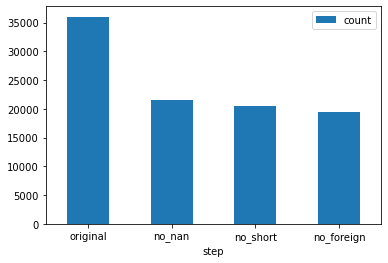

In [63]:
filtering_progress_df = invalid_records(original_df)

display("Original Records: "+str(filtering_progress_df.iloc[0]["count"]))
display("Valid Records: "+str(filtering_progress_df.iloc[-1]["count"]))
ax = filtering_progress_df.plot.bar(x='step', y='count', rot=0)

## 1.6- Term Frequency Distribution

In [69]:
processed = token_lemma_phrasemodeling(original_df['comments'], lemma_tags = ['NOUN', 'ADJ', 'VERB'])
term_freq_distr = term_freq_distribution(processed)
term_freq_df = inspecting_n_most_freq_words(original_df['comments'])

In [270]:
show_quantiles(term_freq_df)

Quantile   Count
3      Q99  460.05
2      Q85   12.00
1      Q75    5.00
0      Q50    1.00

Of a Vocabulary of **11764** terms:

* **1%** of the terms appear **over 460** times
* Only **15%** of the terms appear **12 times or more**
* Half of the terms just once

# 2- Data Cleansing

* 2.1- Removing records with NaN values for comments
* 2.2- Removing records with comments too short to be meaningful
* 2.3- Removing records in other languages
<br><br>
* 2.4- Correcting records containing Non-Alphanumeric for comments
* 2.5- Replacing digits by word "digit"
* 2.6- Removing double white spaces
* 2.7- Normalize comments to lower case
<br><br>

*Not used in final model*
* Translating comments - accuracy was very low
* Correcting spelling mistakes - modifying correct sentences

In [100]:
%%time
warnings.filterwarnings("ignore")
cleansed_df = cleansing_dataset(original_df)

Wall time: 23.3 s


# 3- NLP Processing

*["I am frustrated that it is taking more than digit days to refund a business class ticket."]*
<br><br>

* 3.1- **Tokenization** - Splitting a Sentences into different words

*["I", "am", "frustrated", "that", "it", "is", "taking", "more", "than", "digit", "days", "to", "refund", "a", "business", "class", "ticket"]*

<br><br>
* 3.2- **Lemmatization** - Getting root version of each word. Keeping only Verbs, Nouns, Adjective

*["be", "frustrated", "be", "take", "digit", "day", "refund", "business", "class", "ticket"]*

<br><br>
* 3.3- **Adding Bigrams and Trigrams** - Joining words which tend to appear together

*["be", "frustrated", "be", "take", "digit", "day", "refund", "business_class", "ticket"]*

<br><br>
* 3.4- **Removing Stop Words** - Removing words which don't add much value

*["frustrated", "take", "day", "refund", "business_class", "ticket"]*

In [124]:
%%time
lemma_tags = ['NOUN', 'ADJ', 'VERB']
cleansed_df['comments_processed'] = token_lemma_phrasemodeling_stopwords_multiline(cleansed_df.comments.values.tolist(), custom_stopwords_list, lemma_tags)

Wall time: 4min 15s


## 3.4 Custom Stop Words

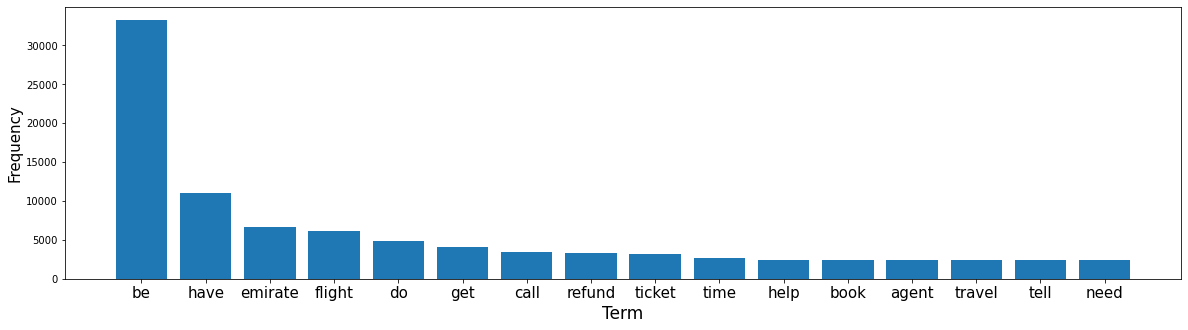

In [271]:
ploting_term_distribution(term_freq_distr)
# After analysing the most common words, we decided to keep the following list
relevant_freq_words = ["flight", "call", "refund", "ticket", "time", "customer", "travel", "help", "book", "agent"]

In [286]:
term_freq_df[term_freq_df['frequency'] < 12].sort_values('frequency', ascending = False).iloc[-5:]

term  frequency
6891       tarring          1
6890   contraction          1
6888         hellp          1
6884      veronica          1
12095   fraudolent          1

In [274]:
custom_Stop_words = generating_custom_stop_words(term_freq_df, relevant_freq_words)

# 4- NLP Transformation - Generating Corpus and Dictionary

* **Dictionary (id2word)** - For Entire Dataset

{0: "admin", 1: "day", ..., 527: "refund" ..., 175: "ticket"}

* **Corpus** - One per Comment

[(34,1), (297,1), (1,1), (527,1), (1426,1), (1756,1)]


In [125]:
id2word, corpus = generating_id2word_and_corpus(cleansed_df['comments_processed'])

# 5- Topic Modeling with LDA

Other models explored BERT and LSA, but discarded since LDA provided better results

## 5.1- Estimating Best Range for Number_Of_ Topics

Using c_v Coherence Score

In [ ]:
%%time
number_topics_range(corpus, id2word, cleansed_df['comments_processed'])

<img src="Best_Num_Topics_CoherenceScore.png" alt="drawing" width="600"/>

## 5.2- Hyperparameter Tunning

* **Topics_number**: [3, 4, 5, 6, 7]
* **Alpha**: [0.1, 0.4, 0.7, symmetric, asymmetric]
* **Eta**: [0.1, 0.4, 0.7, symmetric, asymmetric]

In [289]:
rank_best_parameters = hyperparameter_tunning(3, 7, corpus, id2word, cleansed_df['comments_processed'])
rank_best_parameters.head()

num_topics  alpha        eta  coherence_score
0           5    0.4        0.4         0.611733
1           5    0.4  symmetric         0.607661
2           5    0.7        0.4         0.606667
3           4    0.7  symmetric         0.604338
4           4    0.7        0.7         0.599705

## 5.3- Best Best LDA Model

In [127]:
best_lda_model = compute_lda_model(corpus, id2word, 5, 0.4, 0.4)

## 5.5- Visualizing Cluster Distribution

In [250]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(best_lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.125271  0.045284       1        1  34.490297
1      0.042998 -0.083659       2        1  29.746810
2     -0.252310  0.053410       3        1  15.948809
3      0.115114 -0.249587       4        1  11.592165
4      0.219469  0.234552       5        1   8.221919, topic_info=            Term         Freq        Total Category  logprob  loglift
6         refund  3098.000000  3098.000000  Default  30.0000  30.0000
70        flight  6051.000000  6051.000000  Default  29.0000  29.0000
97   information  1940.000000  1940.000000  Default  28.0000  28.0000
64        ticket  3287.000000  3287.000000  Default  27.0000  27.0000
24          chat  2069.000000  2069.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
8         travel   192.247839  2507.524391   Topic5  -4.4288  -0.0699
12         email   152.508032  1347.642236   Topic5  -4.6604   0.3195
484        clear   124.465976   451.415316   Topic5  -4.8636   1.2100
488         show   115.079725   388.789344   Topic5  -4.9420   1.2810
15          send   116.146282   817.781273   Topic5  -4.9327   0.5466

[317 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
104       1  0.359944  able
104       2  0.318447  able
104       3  0.163283  able
104       4  0.059540  able
104       5  0.098331  able
...     ...       ...   ...
85        5  0.308771  work
136       1  0.417484  year
136       3  0.464665  year
136       4  0.107230  year
136       5  0.010008  year

[515 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

## 5.5- Top Keywords per Topic

In [104]:
# Giving Meaninful names to Topics
topics_mapping = {0 : "Cancelation/Bookings & Covid", 1: "Customer Service", 2: "Ticket/Bookings & Skywards/Upgrades", 3: "Refund Process", 4: "Website Information"}

## 1- Cancelation/Bookings & Covid

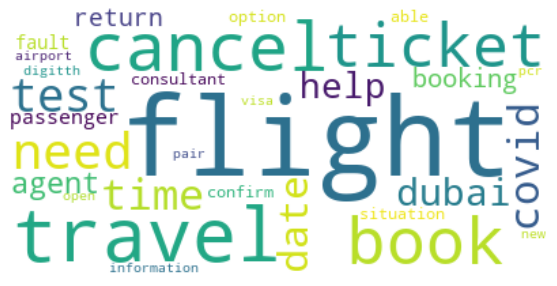

In [306]:
generate_word_cloud(best_lda_model, 0, 30)

## 2- Customer Service

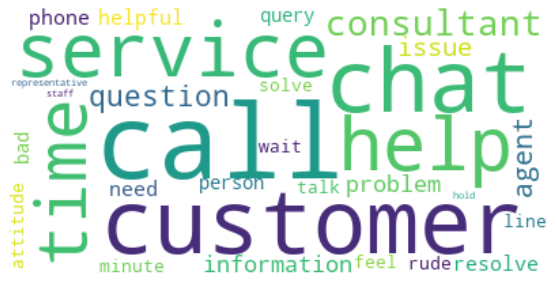

In [307]:
generate_word_cloud(best_lda_model, 1, 30)

## 3- Ticket/Bookings & Skywards/Upgrades

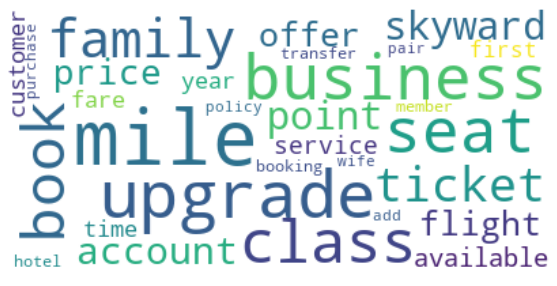

In [308]:
generate_word_cloud(best_lda_model, 2, 30)

## 4- Refund Process

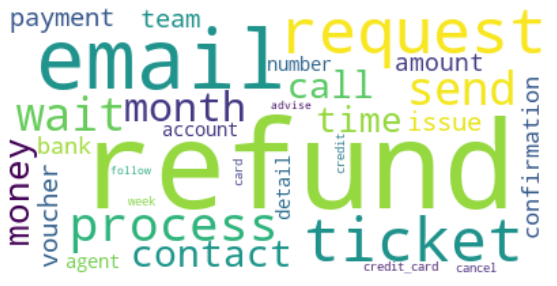

In [309]:
generate_word_cloud(best_lda_model, 3, 30)

## 5- Website Information

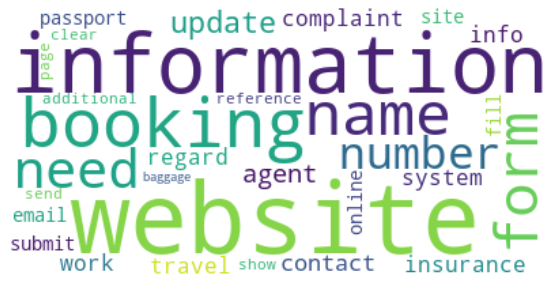

In [310]:
generate_word_cloud(best_lda_model, 4, 30)

## 5.6- Validating Model

In [152]:
clustered_dataset = assign_dominant_topic(best_lda_model, id2word, cleansed_df, topics_mapping)

In [176]:
pd.set_option('display.max_colwidth', None)
clustered_dataset[['comments', 'dominant_topic', 'key_words']].head(10)

comments  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               my travel agent has gone into admin traction and you couldnt give me a price im due for a refund as apparently its encrypted im sure you know how much you charged the agent and i cant contact them   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               he should check the system and confirmed to me that my new email address has been updated as the current email address going to stop soon as i have lost my please any further emails should be sent to this email sosodigitgmailcom   
3                                                                                                                                                                                                   

In [219]:
clustered_dataset[['comments', 'dominant_topic', 'key_words']].to_csv("C:\\Users\\s779205\\Desktop\\JupyterWS\\Dth21-SentimentAnalysis\\demo_output2.csv")

In [261]:
dff = clustered_dataset.explode('dominant_topic')
dff['date_added'] = pd.to_datetime(dff['full_date'],format="%d/%m/%Y")
#list(dff['date_added'].unique())

dff['quarter'] = pd.PeriodIndex(dff.date_added, freq='W')
dff['weekly'] = dff['quarter'].astype(str).str.split('/').str[1]
dff.drop('quarter',axis=1)
df_grouped = dff.groupby(['weekly','dominant_topic']).agg({'comments':'count'}).reset_index()
df_grouped.shape

(156, 3)

In [343]:
dynamic_df = pd.read_csv("dynamicpred_scenarios.csv", engine='python')
test_df = dynamic_df[['Any Comments Suggestions']]
test_df

Any Comments Suggestions
0     No compromise or flexibility either. Not what I would expect from a company such as this airline
1                      Your customer service has declined significantly in past few years. Very upset 
2  The gentleman was unkind did not listen, and impatient tried to refer me to the web site for Cov...
3     Asked whether an upgrade would mean to business class but they I was responded to in an attitude
4                         Very poor service, rude, very rude. Closed chat with finishing conversation 
5                                      I had many issues regarding the refund.no proper response given
6                                                    Not clear with covid policy and test requirements
7                                           Skywards accounts was not credited with miles as committed
8                                         upgrade is too expensive,I wanted to take it but I couldn�t 
9                       emirates.com website doesnot have accurate information about PCR requirements

In [345]:
dynamic = ["Asked whether an upgrade would mean to business class but they I was responded to in an attitude"]

In [346]:
input_test = pd.DataFrame(dynamic, columns = ["comments"])    
input_cleansed = cleansing_dataset(input_test)
input_processed = token_lemma_phrasemodeling(input_cleansed.comments, ['NOUN', 'ADJ', 'VERB'])
input_processed_df = pd.DataFrame([input_processed], columns = ["comments_processed"])   
input_cleansed['corpus_comment'] = input_processed_df.comments_processed.apply(lambda x: generating_corpus_for_text(id2word, x))
dataset = input_cleansed.apply(lambda row: get_dominant_topic_sentence(best_lda_model, row, topics_mapping), axis=1)
dataset

comments  \
0  asked whether an upgrade would mean to business class but they i was responded to in an attitude   

  main_language                                               corpus_comment  \
0            en  [(23, 1), (232, 1), (302, 1), (317, 1), (374, 1), (544, 1)]   

                                            dominant_topic  \
0  [Ticket/Bookings & Skywards/Upgrades, Customer Service]   

                                                                                             key_words  \
0  [[mile, upgrade, business, seat, class, book, family, ticket, skyward, point], [call, customer, ...   

                                                                               topic_score  
0  [(2, 0.54582435), (1, 0.36708534), (0, 0.04971402), (3, 0.020326035), (4, 0.017050222)]

# Topic Distibution - Time Series 

In [353]:
plot_weekly_ts(df_grouped)

# Topic Distibution by Channel - Bar Chart 

In [203]:
df3 = clustered_dataset.explode('dominant_topic')
df_grouped3 = df3.groupby(['channel','dominant_topic']).agg({'comments':'count'}).reset_index()

fig = px.bar(df_grouped3, x='channel', y='comments', color='dominant_topic', labels={'y':'comments'},
             hover_data=['dominant_topic'],
             title='By Channel')
fig.show()

In [218]:
df4 = clustered_dataset.explode('dominant_topic')
df_grouped4 = df4.groupby(['dominant_topic']).agg({'comments':'count'}).reset_index()
df_grouped4

dominant_topic  comments
0         Cancelation/Bookings & Covid      9262
1                     Customer Service     10180
2                       Refund Process      3151
3  Ticket/Bookings & Skywards/Upgrades      3826
4                  Website Information      2348

In [262]:
pop = px.pie(df_grouped4, values='comments', names='dominant_topic',
             title='Topic Distribution',
             hover_data=['dominant_topic'], labels={'lifeExp':'life expectancy'})

pop.update_traces(textposition='inside', textinfo='percent')

pop.show()

# Topic modelling on Unseen DataSet 

In [354]:
#m_comment = """You have cancelled my ticket without prior notice,i have travelling with emirates for so many years. i am not satisfied with your service"""
m_comment = 'i want my money to be credited back to my account'
input_test = pd.DataFrame([m_comment], columns = ["comments"])    
input_cleansed = cleansing_dataset(input_test)
input_processed = token_lemma_phrasemodeling(input_cleansed.comments, ['NOUN', 'ADJ', 'VERB'])
input_processed_df = pd.DataFrame([input_processed], columns = ["comments_processed"])   
input_cleansed['corpus_comment'] = input_processed_df.comments_processed.apply(lambda x: generating_corpus_for_text(id2word, x))
dataset = input_cleansed.apply(lambda row: get_dominant_topic_sentence(best_lda_model, row, topics_mapping), axis=1)
dataset

comments main_language  \
0  i want my money to be credited back to my account            en   

                 corpus_comment    dominant_topic  \
0  [(19, 1), (44, 1), (308, 1)]  [Refund Process]   

                                                                       key_words  \
0  [[refund, email, request, ticket, process, send, wait, month, contact, call]]   

                                                                              topic_score  
0  [(3, 0.7840529), (0, 0.0841673), (1, 0.057496965), (2, 0.044446066), (4, 0.029836753)]

# What Next ?

# 1. Custom StopWords 

# 2. Topic Change Indicator
1. When the number of topic changes 
2. When there is a interchange in top terms.  

<img src="Topic_Change_Indicator.png" alt="drawing" width="600"/>